In [1]:
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata
import math

# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from modules import network,mlp
from utils import yaml_config_hook,save_model

parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

# torch.manual_seed(args.seed)
# torch.cuda.manual_seed_all(args.seed)
# torch.cuda.manual_seed(args.seed)
# np.random.seed(args.seed)
class_num = args.classnum

In [3]:
import scipy.sparse
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
annoData = pd.read_table('data/annoData.txt')
y = annoData["cellIden"].to_numpy()
high_var_gene = args.num_genes
# normlization and feature selection
adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
sc.pp.filter_genes(adataSC, min_cells=10)
adataSC.raw = adataSC
sc.pp.highly_variable_genes(adataSC, n_top_genes=high_var_gene, flavor='seurat_v3')
sc.pp.normalize_total(adataSC, target_sum=1e4)
sc.pp.log1p(adataSC)

adataNorm = adataSC[:, adataSC.var.highly_variable]
dataframe = adataNorm.to_df()
x_ndarray = dataframe.values.squeeze()
y_ndarray = np.expand_dims(y, axis=1)
print(x_ndarray.shape,y_ndarray.shape)
dataframe.head()

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\anndata\_core\anndata.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_name in anno:


(8569, 6000) (8569, 1)


,1,2,4,7,10,13,26,31,32,33,...,20104,20105,20108,20109,20115,20118,20121,20122,20123,20124
0,1.024218,0.0,0.0,0.0000,1.302199,0.0,0.0,0.0,0.637877,0.0,...,0.0000,0.0,0.36896,0.0,0.0000,0.0,0.637877,0.0000,0.000000,0.368960
1,0.000000,0.0,0.0,0.0000,1.351171,0.0,0.0,0.0,0.000000,0.0,...,0.0000,0.0,0.00000,0.0,0.0000,0.0,0.888292,0.0000,0.305824,0.000000
2,0.000000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0000,0.0,0.00000,0.0,0.0000,0.0,0.000000,0.0000,0.000000,0.000000
3,0.000000,0.0,0.0,0.4175,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.4175,0.0,0.00000,0.0,0.4175,0.0,0.937850,0.4175,0.000000,0.000000
4,0.000000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0000,0.0,0.00000,0.0,0.0000,0.0,0.509045,0.0000,0.000000,0.509045


In [4]:
from torch.utils.data import DataLoader,random_split,TensorDataset
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32),
                              torch.tensor(y_ndarray, dtype=torch.float32))

scTrainLength = int(len(scDataset) * 0.8)
scValidLength = len(scDataset) - scTrainLength
scTrain, scValid = random_split(scDataset, [scTrainLength, scValidLength])
# print(scValidLength)
scTrainDataLoader = DataLoader(scTrain, shuffle=True, batch_size=args.batch_size,drop_last=True)
scValidDataLoader = DataLoader(scValid, shuffle=True, batch_size=args.batch_size,drop_last=False)

for features, labels in scTrainDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

6000
1714
1714


In [5]:
# initialize model
mlp = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp, args.feature_dim, args.classnum)
model = model.to('cuda')
# optimizer / loss
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

In [6]:
class InstanceLoss(nn.Module):

    def __init__(self,batch_size,temperature,device):
        super(InstanceLoss,self).__init__()
        self.batch_size=batch_size
        self.temperature=temperature
        self.device=device

        self.mask=self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")


    def mask_correlated_samples(self,batch_size):
        N=2*batch_size
        mask=torch.ones(N,N)
        mask=mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i,batch_size+1]=0
            mask[batch_size+i,i]=0
        mask=mask.bool()
        return mask

    def forward(self,z_i,z_j):
        N=2*self.batch_size
        z=torch.cat((z_i,z_j),dim=0)

        sim=torch.matmul(z,z.T)/self.temperature
        sim_i_j=torch.diag(sim,self.batch_size)
        sim_j_i=torch.diag(sim,-self.batch_size)

        positive_samples= torch.cat((sim_i_j,sim_j_i),dim=0).reshape(N,1)
        negative_samples=sim[self.mask].reshape(N,-1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss

In [7]:
class ClusterLoss(nn.Module):
    def __init__(self, class_num, temperature, device):
        super(ClusterLoss, self).__init__()
        self.class_num = class_num
        self.temperature = temperature
        self.device = device

        self.mask = self.mask_correlated_clusters(class_num)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_clusters(self, class_num):
        N = 2 * class_num
        mask = torch.ones((N, N))
        mask = mask.fill_diagonal_(0)
        for i in range(class_num):
            mask[i, class_num + i] = 0
            mask[class_num + i, i] = 0
        mask = mask.bool()
        return mask

    def forward(self, c_i, c_j):
        p_i = c_i.sum(0).view(-1)
        p_i /= p_i.sum()
        ne_i = math.log(p_i.size(0)) + (p_i * torch.log(p_i)).sum()
        p_j = c_j.sum(0).view(-1)
        p_j /= p_j.sum()
        ne_j = math.log(p_j.size(0)) + (p_j * torch.log(p_j)).sum()
        ne_loss = ne_i + ne_j

        c_i = c_i.t()
        c_j = c_j.t()
        N = 2 * self.class_num
        c = torch.cat((c_i, c_j), dim=0)

        sim = self.similarity_f(c.unsqueeze(1), c.unsqueeze(0)) / self.temperature
        sim_i_j = torch.diag(sim, self.class_num)
        sim_j_i = torch.diag(sim, -self.class_num)

        positive_clusters = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_clusters = sim[self.mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_clusters.device).long()
        logits = torch.cat((positive_clusters, negative_clusters), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss + ne_loss


In [8]:
from preprocessing import transformation
def train(instance_loss,cluster_loss):
    loss_epoch = 0
    for step, (data,label) in enumerate(scTrainDataLoader):
        optimizer.zero_grad()
        
        x_i=data.clone()
        x_j=transformation.transformation(x_i).clone()
        if x_j is not None:
            x_j=x_j.to('cuda')
        else:
            x_j=x_i.clone().to('cuda')
        x_i=x_i.to('cuda')

        # x_i=data.clone().to('cuda')
        # x_j=data.clone().to('cuda')
        
        z_i,z_j,c_i,c_j=model(x_i,x_j)
        loss_instance=instance_loss(z_i,z_j)
        loss_cluster=cluster_loss(c_i,c_j)
        loss = loss_instance + loss_cluster
        loss.backward()
        optimizer.step()
        if step % 10 == 0:
            print(
                f"Step [{step}/{len(scTrainDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
        loss_epoch += loss.item()
    return loss_epoch


In [9]:
def inference(loader, model, device):
    model.eval()
    feature_vector = []
    labels_vector = []
    for step, (x, y) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            c = model.forward_cluster(x)
        c = c.detach()
        feature_vector.extend(c.cpu().detach().numpy())
        labels_vector.extend(y.numpy())
        if step % 20 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")
    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    # print(feature_vector.shape, labels_vector.shape)
    return feature_vector, labels_vector

In [10]:
from evaluation import evaluation
def test():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X, Y = inference(scValidDataLoader, model, device)
    # print(X.shape,Y.shape)
    nmi, ari, f, acc = evaluation.evaluate(Y.reshape(-1), X)
    # print('NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    return nmi, ari, f, acc

In [11]:
loss_device=torch.device('cuda')
instance_loss=InstanceLoss(batch_size=args.batch_size,temperature=0.5,device=loss_device)
cluster_loss=ClusterLoss(class_num=class_num,temperature=0.5,device=loss_device)
accs=[]
losses=[]
for epoch in range(args.start_epoch, args.epochs):
    lr = optimizer.param_groups[0]["lr"]
    loss_epoch = train(instance_loss,cluster_loss)
    losses.append(loss_epoch/len(scTrainDataLoader))
    if epoch % 10 == 0:
        save_model(args, model, optimizer, epoch)
    print(f"\nEpoch [{epoch}/{args.epochs}]\t Loss: {loss_epoch / len(scTrainDataLoader)} \n")
    nmi, ari, f, acc = test()
    accs.append(acc)
    print('Test NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    print('========'*8+'\n')

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.14118480682373	 loss_cluster: 3.2982709407806396

Epoch [0/500]	 Loss: 11.442279815673828 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0408 ARI = 0.0300 F = 0.4098 ACC = 0.2176



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.14181900024414	 loss_cluster: 3.2979445457458496

Epoch [1/500]	 Loss: 11.438958485921225 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0359 ARI = 0.0125 F = 0.4354 ACC = 0.2509



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.140152931213379	 loss_cluster: 3.2976653575897217

Epoch [2/500]	 Loss: 11.43760903676351 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0012 ARI = 0.0002 F = 0.4394 ACC = 0.2555



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139765739440918	 loss_cluster: 3.2975025177001953

Epoch [3/500]	 Loss: 11.437121391296387 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4395 ACC = 0.2555



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139601707458496	 loss_cluster: 3.2972943782806396

Epoch [4/500]	 Loss: 11.436847050984701 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4395 ACC = 0.2555



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139585494995117	 loss_cluster: 3.297130584716797

Epoch [5/500]	 Loss: 11.436641693115234 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4395 ACC = 0.2555



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139541625976562	 loss_cluster: 3.296994686126709

Epoch [6/500]	 Loss: 11.436488151550293 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4395 ACC = 0.2555



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139534950256348	 loss_cluster: 3.296858787536621

Epoch [7/500]	 Loss: 11.43634001413981 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4395 ACC = 0.2555



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139516830444336	 loss_cluster: 3.2967240810394287

Epoch [8/500]	 Loss: 11.436196327209473 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4395 ACC = 0.2555



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139511108398438	 loss_cluster: 3.296602249145508

Epoch [9/500]	 Loss: 11.436068216959635 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4395 ACC = 0.2555



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139503479003906	 loss_cluster: 3.2964818477630615

Epoch [10/500]	 Loss: 11.435942967732748 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4395 ACC = 0.2555



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13949203491211	 loss_cluster: 3.296375036239624

Epoch [11/500]	 Loss: 11.43582820892334 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4395 ACC = 0.2555



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13947582244873	 loss_cluster: 3.2962706089019775

Epoch [12/500]	 Loss: 11.435709635416666 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4395 ACC = 0.2555



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139464378356934	 loss_cluster: 3.2961742877960205

Epoch [13/500]	 Loss: 11.435612996419271 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4395 ACC = 0.2555



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139467239379883	 loss_cluster: 3.296092987060547

Epoch [14/500]	 Loss: 11.435539563496908 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4395 ACC = 0.2555



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139487266540527	 loss_cluster: 3.2960240840911865

Epoch [15/500]	 Loss: 11.43551762898763 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0562 ARI = 0.0129 F = 0.4368 ACC = 0.2538



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139492988586426	 loss_cluster: 3.2959744930267334

Epoch [16/500]	 Loss: 11.435453097025553 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0854 ARI = 0.0288 F = 0.4289 ACC = 0.2450



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139498710632324	 loss_cluster: 3.2959389686584473

Epoch [17/500]	 Loss: 11.435419082641602 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1068 ARI = 0.0408 F = 0.4132 ACC = 0.2211



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139474868774414	 loss_cluster: 3.2959117889404297

Epoch [18/500]	 Loss: 11.435381889343262 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1076 ARI = 0.0470 F = 0.3954 ACC = 0.1989



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139460563659668	 loss_cluster: 3.2958922386169434

Epoch [19/500]	 Loss: 11.43535073598226 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0989 ARI = 0.0458 F = 0.3795 ACC = 0.1756



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139467239379883	 loss_cluster: 3.295877456665039

Epoch [20/500]	 Loss: 11.435340563456217 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1021 ARI = 0.0463 F = 0.3812 ACC = 0.1785



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139459609985352	 loss_cluster: 3.295865058898926

Epoch [21/500]	 Loss: 11.435319900512695 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1228 ARI = 0.0493 F = 0.3905 ACC = 0.1908



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139461517333984	 loss_cluster: 3.2958567142486572

Epoch [22/500]	 Loss: 11.435309092203775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1433 ARI = 0.0522 F = 0.3949 ACC = 0.2089



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295849084854126

Epoch [23/500]	 Loss: 11.435299237569174 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1405 ARI = 0.0632 F = 0.3980 ACC = 0.2036



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945198059082	 loss_cluster: 3.295844793319702

Epoch [24/500]	 Loss: 11.435294469197592 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1385 ARI = 0.0621 F = 0.3762 ACC = 0.1838



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295842409133911

Epoch [25/500]	 Loss: 11.43529224395752 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1506 ARI = 0.0633 F = 0.3573 ACC = 0.1622



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295840263366699

Epoch [26/500]	 Loss: 11.43528683980306 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1617 ARI = 0.0644 F = 0.3298 ACC = 0.3775



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.29584002494812

Epoch [27/500]	 Loss: 11.435288111368815 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1885 ARI = 0.0819 F = 0.3171 ACC = 0.3897



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958390712738037

Epoch [28/500]	 Loss: 11.435287793477377 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2028 ARI = 0.1035 F = 0.3081 ACC = 0.3851



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958383560180664

Epoch [29/500]	 Loss: 11.435286204020182 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2157 ARI = 0.1289 F = 0.3101 ACC = 0.3786



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958381175994873

Epoch [30/500]	 Loss: 11.435288111368815 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2213 ARI = 0.1408 F = 0.3117 ACC = 0.3903



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2958381175994873

Epoch [31/500]	 Loss: 11.435284932454428 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2233 ARI = 0.1453 F = 0.3121 ACC = 0.3973



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2958381175994873

Epoch [32/500]	 Loss: 11.435285568237305 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2239 ARI = 0.1456 F = 0.3097 ACC = 0.4002



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295837163925171

Epoch [33/500]	 Loss: 11.435283025105795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2189 ARI = 0.1356 F = 0.2976 ACC = 0.3926



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295837640762329

Epoch [34/500]	 Loss: 11.435280164082846 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2149 ARI = 0.1275 F = 0.2894 ACC = 0.3821



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295837879180908

Epoch [35/500]	 Loss: 11.435283025105795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2131 ARI = 0.1227 F = 0.2851 ACC = 0.3792



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295837879180908

Epoch [36/500]	 Loss: 11.435282389322916 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2106 ARI = 0.1188 F = 0.2833 ACC = 0.3751



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295837640762329

Epoch [37/500]	 Loss: 11.435280799865723 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2050 ARI = 0.1135 F = 0.2816 ACC = 0.3670



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.295836925506592

Epoch [38/500]	 Loss: 11.435281117757162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2002 ARI = 0.1051 F = 0.2773 ACC = 0.3559



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295836925506592

Epoch [39/500]	 Loss: 11.435281117757162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2000 ARI = 0.1013 F = 0.2769 ACC = 0.3489



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295837163925171

Epoch [40/500]	 Loss: 11.435287793477377 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1965 ARI = 0.0997 F = 0.2778 ACC = 0.3483



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958366870880127

Epoch [41/500]	 Loss: 11.435283978780111 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1965 ARI = 0.0977 F = 0.2781 ACC = 0.3530



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295836925506592

Epoch [42/500]	 Loss: 11.435285250345865 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1923 ARI = 0.0941 F = 0.2777 ACC = 0.3547



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295837163925171

Epoch [43/500]	 Loss: 11.435283342997232 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1923 ARI = 0.0952 F = 0.2792 ACC = 0.3576



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295836925506592

Epoch [44/500]	 Loss: 11.435282707214355 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1926 ARI = 0.0973 F = 0.2813 ACC = 0.3600



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295837163925171

Epoch [45/500]	 Loss: 11.435283978780111 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1937 ARI = 0.0970 F = 0.2810 ACC = 0.3588



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295837163925171

Epoch [46/500]	 Loss: 11.4352814356486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1921 ARI = 0.0957 F = 0.2791 ACC = 0.3559



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295836925506592

Epoch [47/500]	 Loss: 11.435283025105795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1916 ARI = 0.0949 F = 0.2774 ACC = 0.3547



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295836925506592

Epoch [48/500]	 Loss: 11.435282707214355 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1940 ARI = 0.0976 F = 0.2788 ACC = 0.3547



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295836925506592

Epoch [49/500]	 Loss: 11.4352814356486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1947 ARI = 0.0971 F = 0.2758 ACC = 0.3483



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295837163925171

Epoch [50/500]	 Loss: 11.435287157694498 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1943 ARI = 0.0965 F = 0.2732 ACC = 0.3431



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295836925506592

Epoch [51/500]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1980 ARI = 0.1020 F = 0.2758 ACC = 0.3489



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295836925506592

Epoch [52/500]	 Loss: 11.435283342997232 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1962 ARI = 0.0996 F = 0.2745 ACC = 0.3442



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295837163925171

Epoch [53/500]	 Loss: 11.435282071431478 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1974 ARI = 0.1010 F = 0.2737 ACC = 0.3442



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295836925506592

Epoch [54/500]	 Loss: 11.435283978780111 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1964 ARI = 0.1038 F = 0.2758 ACC = 0.3477



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.29583740234375

Epoch [55/500]	 Loss: 11.435290972391764 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1995 ARI = 0.1051 F = 0.2765 ACC = 0.3501



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.29583740234375

Epoch [56/500]	 Loss: 11.435285568237305 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1972 ARI = 0.1037 F = 0.2753 ACC = 0.3495



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295836925506592

Epoch [57/500]	 Loss: 11.435282389322916 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1990 ARI = 0.1043 F = 0.2749 ACC = 0.3495



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295836925506592

Epoch [58/500]	 Loss: 11.435284614562988 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1999 ARI = 0.1050 F = 0.2747 ACC = 0.3524



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.295836925506592

Epoch [59/500]	 Loss: 11.43528683980306 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2012 ARI = 0.1045 F = 0.2752 ACC = 0.3518



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295836925506592

Epoch [60/500]	 Loss: 11.435284296671549 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2006 ARI = 0.1031 F = 0.2742 ACC = 0.3512



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295836925506592

Epoch [61/500]	 Loss: 11.435285568237305 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1995 ARI = 0.1042 F = 0.2749 ACC = 0.3506



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.295836925506592

Epoch [62/500]	 Loss: 11.435289065043131 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2051 ARI = 0.1080 F = 0.2768 ACC = 0.3530



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139459609985352	 loss_cluster: 3.29583740234375

Epoch [63/500]	 Loss: 11.43528938293457 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2048 ARI = 0.1073 F = 0.2761 ACC = 0.3536



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.295837163925171

Epoch [64/500]	 Loss: 11.43528970082601 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2085 ARI = 0.1132 F = 0.2794 ACC = 0.3635



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295836925506592

Epoch [65/500]	 Loss: 11.435284296671549 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2051 ARI = 0.1100 F = 0.2780 ACC = 0.3588



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958366870880127

Epoch [66/500]	 Loss: 11.435283660888672 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2060 ARI = 0.1102 F = 0.2784 ACC = 0.3588



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2958366870880127

Epoch [67/500]	 Loss: 11.4352814356486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2073 ARI = 0.1117 F = 0.2795 ACC = 0.3606



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139455795288086	 loss_cluster: 3.29583740234375

Epoch [68/500]	 Loss: 11.435293833414713 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2051 ARI = 0.1104 F = 0.2782 ACC = 0.3606



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295837163925171

Epoch [69/500]	 Loss: 11.435283025105795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2036 ARI = 0.1070 F = 0.2746 ACC = 0.3559



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.295837163925171

Epoch [70/500]	 Loss: 11.435290018717447 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2034 ARI = 0.1061 F = 0.2739 ACC = 0.3565



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295837163925171

Epoch [71/500]	 Loss: 11.435284614562988 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2027 ARI = 0.1050 F = 0.2725 ACC = 0.3547



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295837163925171

Epoch [72/500]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2016 ARI = 0.1049 F = 0.2728 ACC = 0.3553



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295837163925171

Epoch [73/500]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2037 ARI = 0.1051 F = 0.2739 ACC = 0.3559



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295836925506592

Epoch [74/500]	 Loss: 11.435282707214355 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2077 ARI = 0.1082 F = 0.2773 ACC = 0.3588



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.295836925506592

Epoch [75/500]	 Loss: 11.435287157694498 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2070 ARI = 0.1065 F = 0.2756 ACC = 0.3594



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29583740234375

Epoch [76/500]	 Loss: 11.4352814356486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2033 ARI = 0.1062 F = 0.2749 ACC = 0.3559



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.29583740234375

Epoch [77/500]	 Loss: 11.435282071431478 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2042 ARI = 0.1061 F = 0.2744 ACC = 0.3565



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295836925506592

Epoch [78/500]	 Loss: 11.435282389322916 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2040 ARI = 0.1089 F = 0.2768 ACC = 0.3606



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295837163925171

Epoch [79/500]	 Loss: 11.435282707214355 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2067 ARI = 0.1108 F = 0.2795 ACC = 0.3629



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295837163925171

Epoch [80/500]	 Loss: 11.435279528299967 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2039 ARI = 0.1096 F = 0.2784 ACC = 0.3635



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295837163925171

Epoch [81/500]	 Loss: 11.435281117757162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2064 ARI = 0.1114 F = 0.2799 ACC = 0.3641



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295837163925171

Epoch [82/500]	 Loss: 11.43527921040853 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2062 ARI = 0.1094 F = 0.2777 ACC = 0.3617



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295837163925171

Epoch [83/500]	 Loss: 11.435282389322916 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2058 ARI = 0.1087 F = 0.2780 ACC = 0.3606



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.29583740234375

Epoch [84/500]	 Loss: 11.435283342997232 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2068 ARI = 0.1086 F = 0.2777 ACC = 0.3606



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295837163925171

Epoch [85/500]	 Loss: 11.435279846191406 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2051 ARI = 0.1064 F = 0.2763 ACC = 0.3582



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958364486694336

Epoch [86/500]	 Loss: 11.435284296671549 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2066 ARI = 0.1069 F = 0.2769 ACC = 0.3588



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29583740234375

Epoch [87/500]	 Loss: 11.435280164082846 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2042 ARI = 0.1069 F = 0.2765 ACC = 0.3582



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295837163925171

Epoch [88/500]	 Loss: 11.4352814356486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2073 ARI = 0.1112 F = 0.2793 ACC = 0.3635



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.2958366870880127

Epoch [89/500]	 Loss: 11.43528683980306 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2077 ARI = 0.1103 F = 0.2788 ACC = 0.3646



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295836925506592

Epoch [90/500]	 Loss: 11.435283660888672 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2070 ARI = 0.1085 F = 0.2775 ACC = 0.3617



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295837163925171

Epoch [91/500]	 Loss: 11.435283978780111 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2065 ARI = 0.1099 F = 0.2789 ACC = 0.3641



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958366870880127

Epoch [92/500]	 Loss: 11.435280481974283 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2077 ARI = 0.1086 F = 0.2784 ACC = 0.3635



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958366870880127

Epoch [93/500]	 Loss: 11.435283660888672 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2069 ARI = 0.1105 F = 0.2787 ACC = 0.3635



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945198059082	 loss_cluster: 3.295836925506592

Epoch [94/500]	 Loss: 11.435284932454428 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2102 ARI = 0.1139 F = 0.2808 ACC = 0.3670



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.295837163925171

Epoch [95/500]	 Loss: 11.435284932454428 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2099 ARI = 0.1155 F = 0.2831 ACC = 0.3693



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295837163925171

Epoch [96/500]	 Loss: 11.435285886128744 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2059 ARI = 0.1100 F = 0.2799 ACC = 0.3594



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295836925506592

Epoch [97/500]	 Loss: 11.435283025105795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2028 ARI = 0.1083 F = 0.2788 ACC = 0.3588



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2958364486694336

Epoch [98/500]	 Loss: 11.435285568237305 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2081 ARI = 0.1139 F = 0.2823 ACC = 0.3641



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958366870880127

Epoch [99/500]	 Loss: 11.435285568237305 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2124 ARI = 0.1174 F = 0.2847 ACC = 0.3711



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139458656311035	 loss_cluster: 3.2958364486694336

Epoch [100/500]	 Loss: 11.43528683980306 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2129 ARI = 0.1197 F = 0.2871 ACC = 0.3746



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2958366870880127

Epoch [101/500]	 Loss: 11.435285250345865 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2083 ARI = 0.1134 F = 0.2834 ACC = 0.3658



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295836925506592

Epoch [102/500]	 Loss: 11.43528938293457 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2092 ARI = 0.1135 F = 0.2838 ACC = 0.3658



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295836925506592

Epoch [103/500]	 Loss: 11.435287793477377 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2098 ARI = 0.1154 F = 0.2851 ACC = 0.3705



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958364486694336

Epoch [104/500]	 Loss: 11.435286204020182 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2131 ARI = 0.1191 F = 0.2872 ACC = 0.3740



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945484161377	 loss_cluster: 3.2958364486694336

Epoch [105/500]	 Loss: 11.435286204020182 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2129 ARI = 0.1191 F = 0.2872 ACC = 0.3751



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2958366870880127

Epoch [106/500]	 Loss: 11.435287475585938 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2141 ARI = 0.1195 F = 0.2867 ACC = 0.3769



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.29583740234375

Epoch [107/500]	 Loss: 11.435293833414713 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2120 ARI = 0.1161 F = 0.2843 ACC = 0.3711



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.2958364486694336

Epoch [108/500]	 Loss: 11.435294151306152 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2098 ARI = 0.1139 F = 0.2832 ACC = 0.3693



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958364486694336

Epoch [109/500]	 Loss: 11.435287157694498 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2092 ARI = 0.1145 F = 0.2838 ACC = 0.3681



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295836925506592

Epoch [110/500]	 Loss: 11.43528970082601 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2113 ARI = 0.1162 F = 0.2849 ACC = 0.3734



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958359718322754

Epoch [111/500]	 Loss: 11.435285250345865 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2130 ARI = 0.1161 F = 0.2849 ACC = 0.3711



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295836925506592

Epoch [112/500]	 Loss: 11.435285568237305 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2171 ARI = 0.1184 F = 0.2860 ACC = 0.3751



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2958359718322754

Epoch [113/500]	 Loss: 11.435284296671549 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2165 ARI = 0.1201 F = 0.2882 ACC = 0.3763



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958362102508545

Epoch [114/500]	 Loss: 11.435282389322916 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2100 ARI = 0.1144 F = 0.2844 ACC = 0.3705



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2958362102508545

Epoch [115/500]	 Loss: 11.435284614562988 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2096 ARI = 0.1157 F = 0.2866 ACC = 0.3722



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2958359718322754

Epoch [116/500]	 Loss: 11.435282707214355 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2111 ARI = 0.1173 F = 0.2880 ACC = 0.3751



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958359718322754

Epoch [117/500]	 Loss: 11.435282707214355 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2136 ARI = 0.1171 F = 0.2869 ACC = 0.3740



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958366870880127

Epoch [118/500]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2176 ARI = 0.1226 F = 0.2910 ACC = 0.3821



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2958362102508545

Epoch [119/500]	 Loss: 11.435284296671549 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2203 ARI = 0.1247 F = 0.2923 ACC = 0.3839



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2958359718322754

Epoch [120/500]	 Loss: 11.435282071431478 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2146 ARI = 0.1183 F = 0.2873 ACC = 0.3746



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958364486694336

Epoch [121/500]	 Loss: 11.4352814356486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2101 ARI = 0.1155 F = 0.2862 ACC = 0.3716



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958364486694336

Epoch [122/500]	 Loss: 11.435281117757162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2106 ARI = 0.1154 F = 0.2865 ACC = 0.3711



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958364486694336

Epoch [123/500]	 Loss: 11.435283660888672 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2125 ARI = 0.1193 F = 0.2882 ACC = 0.3775



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958366870880127

Epoch [124/500]	 Loss: 11.435284932454428 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2183 ARI = 0.1225 F = 0.2890 ACC = 0.3821



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2958364486694336

Epoch [125/500]	 Loss: 11.435283660888672 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2209 ARI = 0.1256 F = 0.2929 ACC = 0.3862



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.2958359718322754

Epoch [126/500]	 Loss: 11.435287475585938 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2162 ARI = 0.1203 F = 0.2886 ACC = 0.3798



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2958366870880127

Epoch [127/500]	 Loss: 11.435283025105795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2155 ARI = 0.1188 F = 0.2892 ACC = 0.3792



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2958362102508545

Epoch [128/500]	 Loss: 11.435286521911621 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2173 ARI = 0.1209 F = 0.2901 ACC = 0.3821



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295835256576538

Epoch [129/500]	 Loss: 11.435283025105795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2197 ARI = 0.1229 F = 0.2914 ACC = 0.3845



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958362102508545

Epoch [130/500]	 Loss: 11.43529192606608 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2192 ARI = 0.1227 F = 0.2909 ACC = 0.3827



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.2958364486694336

Epoch [131/500]	 Loss: 11.435286204020182 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2172 ARI = 0.1213 F = 0.2892 ACC = 0.3816



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.2958362102508545

Epoch [132/500]	 Loss: 11.435286204020182 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2169 ARI = 0.1208 F = 0.2889 ACC = 0.3810



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958357334136963

Epoch [133/500]	 Loss: 11.435281117757162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2195 ARI = 0.1243 F = 0.2918 ACC = 0.3845



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958359718322754

Epoch [134/500]	 Loss: 11.435283025105795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2157 ARI = 0.1204 F = 0.2896 ACC = 0.3833



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295835494995117

Epoch [135/500]	 Loss: 11.4352814356486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2182 ARI = 0.1217 F = 0.2915 ACC = 0.3856



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958362102508545

Epoch [136/500]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2168 ARI = 0.1196 F = 0.2897 ACC = 0.3827



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958359718322754

Epoch [137/500]	 Loss: 11.435279846191406 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2180 ARI = 0.1184 F = 0.2881 ACC = 0.3821



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958362102508545

Epoch [138/500]	 Loss: 11.43527921040853 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2203 ARI = 0.1217 F = 0.2902 ACC = 0.3862



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2958362102508545

Epoch [139/500]	 Loss: 11.435278256734213 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2196 ARI = 0.1233 F = 0.2913 ACC = 0.3880



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139439582824707	 loss_cluster: 3.2958362102508545

Epoch [140/500]	 Loss: 11.435277620951334 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2241 ARI = 0.1270 F = 0.2942 ACC = 0.3897



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958362102508545

Epoch [141/500]	 Loss: 11.435279846191406 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2206 ARI = 0.1247 F = 0.2931 ACC = 0.3874



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958359718322754

Epoch [142/500]	 Loss: 11.4352814356486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2252 ARI = 0.1297 F = 0.2977 ACC = 0.3956



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2958362102508545

Epoch [143/500]	 Loss: 11.435282707214355 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2221 ARI = 0.1275 F = 0.2961 ACC = 0.3938



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958359718322754

Epoch [144/500]	 Loss: 11.435282389322916 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2229 ARI = 0.1298 F = 0.2984 ACC = 0.3961



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2958364486694336

Epoch [145/500]	 Loss: 11.435283025105795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2252 ARI = 0.1323 F = 0.3005 ACC = 0.3979



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.295835494995117

Epoch [146/500]	 Loss: 11.4352814356486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2270 ARI = 0.1314 F = 0.2992 ACC = 0.3979



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958357334136963

Epoch [147/500]	 Loss: 11.435282707214355 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2272 ARI = 0.1341 F = 0.3020 ACC = 0.4008



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2958362102508545

Epoch [148/500]	 Loss: 11.435279528299967 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2255 ARI = 0.1326 F = 0.3009 ACC = 0.3979



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2958362102508545

Epoch [149/500]	 Loss: 11.43527857462565 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2247 ARI = 0.1298 F = 0.2986 ACC = 0.3973



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2958359718322754

Epoch [150/500]	 Loss: 11.43527857462565 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2249 ARI = 0.1286 F = 0.2976 ACC = 0.3961



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2958362102508545

Epoch [151/500]	 Loss: 11.43527857462565 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2261 ARI = 0.1287 F = 0.2979 ACC = 0.3944



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2958362102508545

Epoch [152/500]	 Loss: 11.435280164082846 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2252 ARI = 0.1284 F = 0.2982 ACC = 0.3932



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958357334136963

Epoch [153/500]	 Loss: 11.435281117757162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2240 ARI = 0.1270 F = 0.2968 ACC = 0.3915



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958359718322754

Epoch [154/500]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2205 ARI = 0.1269 F = 0.2968 ACC = 0.3926



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295835018157959

Epoch [155/500]	 Loss: 11.435279528299967 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2249 ARI = 0.1320 F = 0.3011 ACC = 0.3996



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958362102508545

Epoch [156/500]	 Loss: 11.435282707214355 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2270 ARI = 0.1319 F = 0.3011 ACC = 0.3991



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2958357334136963

Epoch [157/500]	 Loss: 11.435279846191406 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2292 ARI = 0.1346 F = 0.3028 ACC = 0.4008



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958359718322754

Epoch [158/500]	 Loss: 11.435280164082846 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2309 ARI = 0.1409 F = 0.3086 ACC = 0.4090



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958359718322754

Epoch [159/500]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2323 ARI = 0.1424 F = 0.3103 ACC = 0.4125



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295835494995117

Epoch [160/500]	 Loss: 11.435280481974283 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2296 ARI = 0.1430 F = 0.3113 ACC = 0.4131



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958359718322754

Epoch [161/500]	 Loss: 11.435282071431478 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2300 ARI = 0.1408 F = 0.3100 ACC = 0.4113



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2958359718322754

Epoch [162/500]	 Loss: 11.4352814356486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2307 ARI = 0.1393 F = 0.3086 ACC = 0.4078



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2958359718322754

Epoch [163/500]	 Loss: 11.435280799865723 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2310 ARI = 0.1427 F = 0.3109 ACC = 0.4125



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2958364486694336

Epoch [164/500]	 Loss: 11.435284296671549 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2319 ARI = 0.1448 F = 0.3120 ACC = 0.4131



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2958364486694336

Epoch [165/500]	 Loss: 11.435284614562988 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2322 ARI = 0.1441 F = 0.3115 ACC = 0.4125



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958364486694336

Epoch [166/500]	 Loss: 11.435283978780111 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2309 ARI = 0.1437 F = 0.3120 ACC = 0.4113



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2958364486694336

Epoch [167/500]	 Loss: 11.435280164082846 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2311 ARI = 0.1436 F = 0.3124 ACC = 0.4119



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2958359718322754

Epoch [168/500]	 Loss: 11.43527889251709 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2304 ARI = 0.1414 F = 0.3105 ACC = 0.4090



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2958357334136963

Epoch [169/500]	 Loss: 11.43527857462565 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2258 ARI = 0.1380 F = 0.3097 ACC = 0.4072



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2958359718322754

Epoch [170/500]	 Loss: 11.435280164082846 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2309 ARI = 0.1418 F = 0.3113 ACC = 0.4102



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958362102508545

Epoch [171/500]	 Loss: 11.435281117757162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2324 ARI = 0.1442 F = 0.3132 ACC = 0.4137



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958364486694336

Epoch [172/500]	 Loss: 11.435281117757162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2333 ARI = 0.1435 F = 0.3128 ACC = 0.4131



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958362102508545

Epoch [173/500]	 Loss: 11.435280164082846 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2326 ARI = 0.1430 F = 0.3136 ACC = 0.4107



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295835256576538

Epoch [174/500]	 Loss: 11.435280164082846 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2366 ARI = 0.1472 F = 0.3170 ACC = 0.4148



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295835256576538

Epoch [175/500]	 Loss: 11.435280799865723 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2336 ARI = 0.1437 F = 0.3152 ACC = 0.4125



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295835494995117

Epoch [176/500]	 Loss: 11.435280799865723 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2315 ARI = 0.1436 F = 0.3157 ACC = 0.4131



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295835256576538

Epoch [177/500]	 Loss: 11.4352814356486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2351 ARI = 0.1491 F = 0.3207 ACC = 0.4183



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2958359718322754

Epoch [178/500]	 Loss: 11.435282389322916 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2334 ARI = 0.1486 F = 0.3208 ACC = 0.4166



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295835494995117

Epoch [179/500]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2357 ARI = 0.1493 F = 0.3217 ACC = 0.4201



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958359718322754

Epoch [180/500]	 Loss: 11.435283025105795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2353 ARI = 0.1492 F = 0.3213 ACC = 0.4189



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958359718322754

Epoch [181/500]	 Loss: 11.435283978780111 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2315 ARI = 0.1464 F = 0.3194 ACC = 0.4125



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958362102508545

Epoch [182/500]	 Loss: 11.435279846191406 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2303 ARI = 0.1463 F = 0.3190 ACC = 0.4125



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2958359718322754

Epoch [183/500]	 Loss: 11.435278256734213 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2375 ARI = 0.1512 F = 0.3229 ACC = 0.4201



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958359718322754

Epoch [184/500]	 Loss: 11.43527921040853 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2385 ARI = 0.1510 F = 0.3232 ACC = 0.4201



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295835494995117

Epoch [185/500]	 Loss: 11.435280164082846 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2346 ARI = 0.1485 F = 0.3221 ACC = 0.4166



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295835256576538

Epoch [186/500]	 Loss: 11.435278256734213 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2358 ARI = 0.1480 F = 0.3226 ACC = 0.4148



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.2958359718322754

Epoch [187/500]	 Loss: 11.43527889251709 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2419 ARI = 0.1555 F = 0.3274 ACC = 0.4242



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295835018157959

Epoch [188/500]	 Loss: 11.435279528299967 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2418 ARI = 0.1558 F = 0.3274 ACC = 0.4247



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295835018157959

Epoch [189/500]	 Loss: 11.435280164082846 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2425 ARI = 0.1562 F = 0.3276 ACC = 0.4236



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295835256576538

Epoch [190/500]	 Loss: 11.435280481974283 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2455 ARI = 0.1583 F = 0.3299 ACC = 0.4247



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958362102508545

Epoch [191/500]	 Loss: 11.435283342997232 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2475 ARI = 0.1590 F = 0.3308 ACC = 0.4242



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295835494995117

Epoch [192/500]	 Loss: 11.435284614562988 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2483 ARI = 0.1596 F = 0.3329 ACC = 0.4247



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.295835018157959

Epoch [193/500]	 Loss: 11.435284614562988 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2446 ARI = 0.1567 F = 0.3308 ACC = 0.4224



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295835494995117

Epoch [194/500]	 Loss: 11.435285568237305 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2477 ARI = 0.1607 F = 0.3345 ACC = 0.4236



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295835256576538

Epoch [195/500]	 Loss: 11.435286204020182 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2497 ARI = 0.1632 F = 0.3367 ACC = 0.4271



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.295835018157959

Epoch [196/500]	 Loss: 11.435285250345865 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2492 ARI = 0.1634 F = 0.3373 ACC = 0.4265



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958357334136963

Epoch [197/500]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2509 ARI = 0.1638 F = 0.3381 ACC = 0.4265



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295835256576538

Epoch [198/500]	 Loss: 11.435284296671549 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2530 ARI = 0.1683 F = 0.3435 ACC = 0.4323



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.29583477973938

Epoch [199/500]	 Loss: 11.435283025105795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2521 ARI = 0.1699 F = 0.3444 ACC = 0.4317



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.2958357334136963

Epoch [200/500]	 Loss: 11.435286521911621 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2534 ARI = 0.1715 F = 0.3454 ACC = 0.4335



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295835018157959

Epoch [201/500]	 Loss: 11.435280799865723 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2544 ARI = 0.1701 F = 0.3446 ACC = 0.4323



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2958357334136963

Epoch [202/500]	 Loss: 11.435280481974283 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2543 ARI = 0.1718 F = 0.3465 ACC = 0.4347



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295835256576538

Epoch [203/500]	 Loss: 11.435279528299967 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2543 ARI = 0.1716 F = 0.3466 ACC = 0.4323



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295835256576538

Epoch [204/500]	 Loss: 11.435282707214355 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2544 ARI = 0.1705 F = 0.3470 ACC = 0.4317



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.295835256576538

Epoch [205/500]	 Loss: 11.435283025105795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2616 ARI = 0.1744 F = 0.3491 ACC = 0.4341



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295835494995117

Epoch [206/500]	 Loss: 11.435282389322916 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2624 ARI = 0.1740 F = 0.3502 ACC = 0.4341



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139455795288086	 loss_cluster: 3.295835018157959

Epoch [207/500]	 Loss: 11.435287157694498 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2667 ARI = 0.1785 F = 0.3543 ACC = 0.4370



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295834541320801

Epoch [208/500]	 Loss: 11.435284614562988 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2683 ARI = 0.1820 F = 0.3575 ACC = 0.4405



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295835018157959

Epoch [209/500]	 Loss: 11.435283342997232 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2678 ARI = 0.1807 F = 0.3575 ACC = 0.4382



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295835018157959

Epoch [210/500]	 Loss: 11.435279528299967 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2750 ARI = 0.1900 F = 0.3654 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295835018157959

Epoch [211/500]	 Loss: 11.435280164082846 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2707 ARI = 0.1853 F = 0.3631 ACC = 0.4434



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29583477973938

Epoch [212/500]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2680 ARI = 0.1821 F = 0.3612 ACC = 0.4376



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.295834541320801

Epoch [213/500]	 Loss: 11.435279846191406 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2708 ARI = 0.1839 F = 0.3627 ACC = 0.4387



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2958340644836426

Epoch [214/500]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2742 ARI = 0.1918 F = 0.3695 ACC = 0.4481



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295834541320801

Epoch [215/500]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2811 ARI = 0.1944 F = 0.3728 ACC = 0.4510



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.29583477973938

Epoch [216/500]	 Loss: 11.4352814356486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2847 ARI = 0.1994 F = 0.3793 ACC = 0.0875



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295834541320801

Epoch [217/500]	 Loss: 11.43527921040853 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2856 ARI = 0.2012 F = 0.3819 ACC = 0.0945



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29583477973938

Epoch [218/500]	 Loss: 11.435276667277018 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2897 ARI = 0.2079 F = 0.3885 ACC = 0.0858



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295834541320801

Epoch [219/500]	 Loss: 11.43527857462565 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2955 ARI = 0.2153 F = 0.3966 ACC = 0.0928



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.29583477973938

Epoch [220/500]	 Loss: 11.43527857462565 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2967 ARI = 0.2150 F = 0.3974 ACC = 0.0945



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958340644836426

Epoch [221/500]	 Loss: 11.4352814356486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2899 ARI = 0.2112 F = 0.3956 ACC = 0.0968



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958333492279053

Epoch [222/500]	 Loss: 11.4352814356486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2915 ARI = 0.2099 F = 0.3945 ACC = 0.0963



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295834541320801

Epoch [223/500]	 Loss: 11.43527857462565 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3001 ARI = 0.2158 F = 0.4007 ACC = 0.4632



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2958333492279053

Epoch [224/500]	 Loss: 11.435277620951334 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3069 ARI = 0.2221 F = 0.4080 ACC = 0.4691



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958335876464844

Epoch [225/500]	 Loss: 11.43527857462565 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3091 ARI = 0.2250 F = 0.4125 ACC = 0.4691



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958335876464844

Epoch [226/500]	 Loss: 11.435279528299967 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3114 ARI = 0.2281 F = 0.4163 ACC = 0.4702



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958343029022217

Epoch [227/500]	 Loss: 11.435276985168457 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3196 ARI = 0.2311 F = 0.4232 ACC = 0.4714



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295832872390747

Epoch [228/500]	 Loss: 11.435276667277018 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3184 ARI = 0.2290 F = 0.4217 ACC = 0.4627



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958333492279053

Epoch [229/500]	 Loss: 11.435280164082846 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3203 ARI = 0.2308 F = 0.4261 ACC = 0.4597



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295832395553589

Epoch [230/500]	 Loss: 11.435278256734213 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3223 ARI = 0.2304 F = 0.4244 ACC = 0.4597



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2958316802978516

Epoch [231/500]	 Loss: 11.435275713602701 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3257 ARI = 0.2307 F = 0.4276 ACC = 0.4545



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958314418792725

Epoch [232/500]	 Loss: 11.435276985168457 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3273 ARI = 0.2340 F = 0.4342 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958314418792725

Epoch [233/500]	 Loss: 11.435277303059896 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3354 ARI = 0.2364 F = 0.4414 ACC = 0.4580



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958312034606934

Epoch [234/500]	 Loss: 11.435275077819824 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3385 ARI = 0.2383 F = 0.4439 ACC = 0.4586



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295830488204956

Epoch [235/500]	 Loss: 11.43527348836263 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3474 ARI = 0.2418 F = 0.4522 ACC = 0.4644



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295830488204956

Epoch [236/500]	 Loss: 11.435274124145508 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3470 ARI = 0.2422 F = 0.4540 ACC = 0.4586



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2958297729492188

Epoch [237/500]	 Loss: 11.435274442036947 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3500 ARI = 0.2454 F = 0.4605 ACC = 0.4592



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2958288192749023

Epoch [238/500]	 Loss: 11.435274124145508 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3545 ARI = 0.2484 F = 0.4676 ACC = 0.4597



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295827865600586

Epoch [239/500]	 Loss: 11.435274442036947 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3576 ARI = 0.2505 F = 0.4695 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295828104019165

Epoch [240/500]	 Loss: 11.435276667277018 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3660 ARI = 0.2562 F = 0.4779 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13947582244873	 loss_cluster: 3.295827627182007

Epoch [241/500]	 Loss: 11.435297012329102 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3695 ARI = 0.2573 F = 0.4786 ACC = 0.4510



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295825242996216

Epoch [242/500]	 Loss: 11.435275395711264 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3770 ARI = 0.2605 F = 0.4856 ACC = 0.4469



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.2958240509033203

Epoch [243/500]	 Loss: 11.435277303059896 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3799 ARI = 0.2623 F = 0.4925 ACC = 0.4492



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.1394624710083	 loss_cluster: 3.295823335647583

Epoch [244/500]	 Loss: 11.435276667277018 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3797 ARI = 0.2631 F = 0.4961 ACC = 0.4446



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2958216667175293

Epoch [245/500]	 Loss: 11.435273170471191 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3854 ARI = 0.2674 F = 0.5007 ACC = 0.4481



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295820474624634

Epoch [246/500]	 Loss: 11.435269673665365 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3853 ARI = 0.2678 F = 0.5022 ACC = 0.4527



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945198059082	 loss_cluster: 3.295819044113159

Epoch [247/500]	 Loss: 11.435267766316732 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3922 ARI = 0.2717 F = 0.5065 ACC = 0.4586



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.29581618309021

Epoch [248/500]	 Loss: 11.435261726379395 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3971 ARI = 0.2739 F = 0.5083 ACC = 0.4650



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2958133220672607

Epoch [249/500]	 Loss: 11.435260136922201 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4016 ARI = 0.2790 F = 0.5148 ACC = 0.1972



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958109378814697

Epoch [250/500]	 Loss: 11.43525759379069 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4099 ARI = 0.2827 F = 0.5178 ACC = 0.2001



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958078384399414

Epoch [251/500]	 Loss: 11.435254096984863 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4133 ARI = 0.2861 F = 0.5220 ACC = 0.2013



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295804262161255

Epoch [252/500]	 Loss: 11.435249964396158 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4148 ARI = 0.2879 F = 0.5242 ACC = 0.2054



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2957985401153564

Epoch [253/500]	 Loss: 11.435244878133139 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4172 ARI = 0.2932 F = 0.5261 ACC = 0.4749



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2957961559295654

Epoch [254/500]	 Loss: 11.435240427652994 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4227 ARI = 0.2984 F = 0.5275 ACC = 0.4778



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2957863807678223

Epoch [255/500]	 Loss: 11.435236612955729 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4304 ARI = 0.3043 F = 0.5266 ACC = 0.1972



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945198059082	 loss_cluster: 3.2957816123962402

Epoch [256/500]	 Loss: 11.435231844584147 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4277 ARI = 0.3057 F = 0.5261 ACC = 0.1960



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2957725524902344

Epoch [257/500]	 Loss: 11.435220718383789 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4285 ARI = 0.3070 F = 0.5252 ACC = 0.1954



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2957656383514404

Epoch [258/500]	 Loss: 11.435208638509115 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4323 ARI = 0.3097 F = 0.5261 ACC = 0.1978



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139458656311035	 loss_cluster: 3.295755624771118

Epoch [259/500]	 Loss: 11.435205459594727 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4305 ARI = 0.3075 F = 0.5191 ACC = 0.0706



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945484161377	 loss_cluster: 3.295741081237793

Epoch [260/500]	 Loss: 11.435187339782715 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4229 ARI = 0.2973 F = 0.5030 ACC = 0.0712



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2957277297973633

Epoch [261/500]	 Loss: 11.435171763102213 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4111 ARI = 0.2810 F = 0.4807 ACC = 0.0753



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.295705556869507

Epoch [262/500]	 Loss: 11.435151100158691 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3916 ARI = 0.2537 F = 0.4551 ACC = 0.0473



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945198059082	 loss_cluster: 3.2956960201263428

Epoch [263/500]	 Loss: 11.435133616129557 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3713 ARI = 0.2260 F = 0.4336 ACC = 0.0432



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.295667886734009

Epoch [264/500]	 Loss: 11.435107549031576 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3489 ARI = 0.1840 F = 0.4111 ACC = 0.0373



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139457702636719	 loss_cluster: 3.295637845993042

Epoch [265/500]	 Loss: 11.435085614522299 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3380 ARI = 0.1608 F = 0.4077 ACC = 0.0333



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139459609985352	 loss_cluster: 3.2956104278564453

Epoch [266/500]	 Loss: 11.435059865315756 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3311 ARI = 0.1371 F = 0.4165 ACC = 0.0274



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.2955868244171143

Epoch [267/500]	 Loss: 11.435035387674967 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3202 ARI = 0.1243 F = 0.4393 ACC = 0.0181



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.2955563068389893

Epoch [268/500]	 Loss: 11.435003280639648 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3245 ARI = 0.1265 F = 0.4622 ACC = 0.0023



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139458656311035	 loss_cluster: 3.2955615520477295

Epoch [269/500]	 Loss: 11.434991518656412 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3204 ARI = 0.1269 F = 0.4798 ACC = 0.0047



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139458656311035	 loss_cluster: 3.295525074005127

Epoch [270/500]	 Loss: 11.434975624084473 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3174 ARI = 0.1255 F = 0.4847 ACC = 0.0193



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.2955055236816406

Epoch [271/500]	 Loss: 11.434946060180664 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3205 ARI = 0.1269 F = 0.4863 ACC = 0.0082



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.295498847961426

Epoch [272/500]	 Loss: 11.43494955698649 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3100 ARI = 0.1214 F = 0.4851 ACC = 0.0023



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139471054077148	 loss_cluster: 3.295473098754883

Epoch [273/500]	 Loss: 11.434943199157715 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3040 ARI = 0.1190 F = 0.4844 ACC = 0.0187



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139472961425781	 loss_cluster: 3.2954695224761963

Epoch [274/500]	 Loss: 11.434941927591959 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3044 ARI = 0.1191 F = 0.4842 ACC = 0.0023



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139466285705566	 loss_cluster: 3.2954599857330322

Epoch [275/500]	 Loss: 11.43493938446045 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3030 ARI = 0.1200 F = 0.4836 ACC = 0.0041



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.1394624710083	 loss_cluster: 3.295447826385498

Epoch [276/500]	 Loss: 11.434909184773764 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3010 ARI = 0.1183 F = 0.4838 ACC = 0.0187



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.2954375743865967

Epoch [277/500]	 Loss: 11.4348996480306 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3007 ARI = 0.1188 F = 0.4839 ACC = 0.0193



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2954533100128174

Epoch [278/500]	 Loss: 11.434893290201822 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2984 ARI = 0.1203 F = 0.4833 ACC = 0.0023



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295433759689331

Epoch [279/500]	 Loss: 11.434892336527506 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2961 ARI = 0.1204 F = 0.4816 ACC = 0.0105



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139472961425781	 loss_cluster: 3.2954251766204834

Epoch [280/500]	 Loss: 11.434899965922037 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2956 ARI = 0.1197 F = 0.4794 ACC = 0.0053



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295440435409546

Epoch [281/500]	 Loss: 11.434879938761393 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2958 ARI = 0.1210 F = 0.4714 ACC = 0.0111



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.295430898666382

Epoch [282/500]	 Loss: 11.434898376464844 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2915 ARI = 0.1187 F = 0.4611 ACC = 0.0053



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295426607131958

Epoch [283/500]	 Loss: 11.434876124064127 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2872 ARI = 0.1179 F = 0.4552 ACC = 0.4049



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.295414686203003

Epoch [284/500]	 Loss: 11.43487517038981 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2847 ARI = 0.1199 F = 0.4497 ACC = 0.0566



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2954366207122803

Epoch [285/500]	 Loss: 11.434868176778158 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2827 ARI = 0.1188 F = 0.4347 ACC = 0.0146



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2954115867614746

Epoch [286/500]	 Loss: 11.434863090515137 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2796 ARI = 0.1150 F = 0.4142 ACC = 0.0181



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2954180240631104

Epoch [287/500]	 Loss: 11.434860547383627 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2744 ARI = 0.1189 F = 0.4023 ACC = 0.0309



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295412302017212

Epoch [288/500]	 Loss: 11.434858957926432 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2732 ARI = 0.1166 F = 0.3931 ACC = 0.0333



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2954158782958984

Epoch [289/500]	 Loss: 11.434857686360678 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2713 ARI = 0.1194 F = 0.3835 ACC = 0.0298



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2954137325286865

Epoch [290/500]	 Loss: 11.434853871663412 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2715 ARI = 0.1232 F = 0.3787 ACC = 0.0327



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2954061031341553

Epoch [291/500]	 Loss: 11.434857050577799 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2728 ARI = 0.1257 F = 0.3754 ACC = 0.0327



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2954208850860596

Epoch [292/500]	 Loss: 11.434850692749023 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2706 ARI = 0.1268 F = 0.3726 ACC = 0.0408



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295417308807373

Epoch [293/500]	 Loss: 11.434858957926432 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2725 ARI = 0.1281 F = 0.3702 ACC = 0.0350



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2954087257385254

Epoch [294/500]	 Loss: 11.434849739074707 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2713 ARI = 0.1276 F = 0.3701 ACC = 0.0373



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953996658325195

Epoch [295/500]	 Loss: 11.434845924377441 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2744 ARI = 0.1302 F = 0.3706 ACC = 0.0053



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953970432281494

Epoch [296/500]	 Loss: 11.434839884440104 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2724 ARI = 0.1322 F = 0.3697 ACC = 0.0041



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2954108715057373

Epoch [297/500]	 Loss: 11.434858640034994 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2723 ARI = 0.1357 F = 0.3698 ACC = 0.1803



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953977584838867

Epoch [298/500]	 Loss: 11.434840202331543 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2710 ARI = 0.1348 F = 0.3682 ACC = 0.1809



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2954068183898926

Epoch [299/500]	 Loss: 11.434843381245932 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2750 ARI = 0.1389 F = 0.3712 ACC = 0.1861



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295410394668579

Epoch [300/500]	 Loss: 11.434865315755209 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2840 ARI = 0.1453 F = 0.3712 ACC = 0.1908



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295398712158203

Epoch [301/500]	 Loss: 11.434852282206217 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3034 ARI = 0.1559 F = 0.3752 ACC = 0.1931



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953948974609375

Epoch [302/500]	 Loss: 11.434853871663412 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2969 ARI = 0.1540 F = 0.3777 ACC = 0.1960



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295388698577881

Epoch [303/500]	 Loss: 11.434841473897299 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3035 ARI = 0.1652 F = 0.3849 ACC = 0.2065



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2954046726226807

Epoch [304/500]	 Loss: 11.434867223103842 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3398 ARI = 0.1850 F = 0.3934 ACC = 0.4527



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.29539155960083

Epoch [305/500]	 Loss: 11.434837659200033 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3425 ARI = 0.1834 F = 0.3861 ACC = 0.4609



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2954115867614746

Epoch [306/500]	 Loss: 11.434863726298014 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3488 ARI = 0.1921 F = 0.3877 ACC = 0.4872



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2954318523406982

Epoch [307/500]	 Loss: 11.434849739074707 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3350 ARI = 0.1834 F = 0.3933 ACC = 0.4726



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295396327972412

Epoch [308/500]	 Loss: 11.43484369913737 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3414 ARI = 0.1905 F = 0.4019 ACC = 0.4673



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953951358795166

Epoch [309/500]	 Loss: 11.434837341308594 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3552 ARI = 0.2037 F = 0.4034 ACC = 0.4767



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295416831970215

Epoch [310/500]	 Loss: 11.434859911600748 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3570 ARI = 0.2071 F = 0.4022 ACC = 0.4848



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295398473739624

Epoch [311/500]	 Loss: 11.434858322143555 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3560 ARI = 0.2060 F = 0.4061 ACC = 0.4877



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953860759735107

Epoch [312/500]	 Loss: 11.434837023417154 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3442 ARI = 0.1986 F = 0.4095 ACC = 0.4749



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2953872680664062

Epoch [313/500]	 Loss: 11.43483797709147 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3543 ARI = 0.2082 F = 0.4078 ACC = 0.4726



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295386791229248

Epoch [314/500]	 Loss: 11.434837023417154 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3585 ARI = 0.2139 F = 0.3927 ACC = 0.4720



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953903675079346

Epoch [315/500]	 Loss: 11.43483797709147 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3562 ARI = 0.2151 F = 0.3912 ACC = 0.4662



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295396089553833

Epoch [316/500]	 Loss: 11.434844017028809 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3508 ARI = 0.2119 F = 0.3871 ACC = 0.4632



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295400619506836

Epoch [317/500]	 Loss: 11.43483797709147 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3477 ARI = 0.2113 F = 0.3906 ACC = 0.4650



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953872680664062

Epoch [318/500]	 Loss: 11.434832255045572 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3500 ARI = 0.2122 F = 0.3908 ACC = 0.4650



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953896522521973

Epoch [319/500]	 Loss: 11.434832255045572 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3495 ARI = 0.2112 F = 0.3886 ACC = 0.4638



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953951358795166

Epoch [320/500]	 Loss: 11.434833526611328 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3525 ARI = 0.2139 F = 0.3893 ACC = 0.4667



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295396566390991

Epoch [321/500]	 Loss: 11.434837023417154 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3525 ARI = 0.2133 F = 0.3835 ACC = 0.4650



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295388698577881

Epoch [322/500]	 Loss: 11.434837023417154 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3480 ARI = 0.2088 F = 0.3774 ACC = 0.4580



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953948974609375

Epoch [323/500]	 Loss: 11.434837341308594 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3498 ARI = 0.2101 F = 0.3791 ACC = 0.4592



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2953920364379883

Epoch [324/500]	 Loss: 11.43483829498291 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3506 ARI = 0.2061 F = 0.3783 ACC = 0.4586



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295393705368042

Epoch [325/500]	 Loss: 11.434832890828451 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3469 ARI = 0.2034 F = 0.3787 ACC = 0.4574



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953882217407227

Epoch [326/500]	 Loss: 11.434832255045572 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3426 ARI = 0.1985 F = 0.3725 ACC = 0.4522



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.29538893699646

Epoch [327/500]	 Loss: 11.434829711914062 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3392 ARI = 0.1977 F = 0.3705 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295396566390991

Epoch [328/500]	 Loss: 11.43483861287435 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3423 ARI = 0.1998 F = 0.3767 ACC = 0.4516



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2953994274139404

Epoch [329/500]	 Loss: 11.434833844502768 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3425 ARI = 0.1932 F = 0.3685 ACC = 0.4510



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953829765319824

Epoch [330/500]	 Loss: 11.434832890828451 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3446 ARI = 0.1967 F = 0.3687 ACC = 0.4516



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2954015731811523

Epoch [331/500]	 Loss: 11.434846878051758 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3458 ARI = 0.2008 F = 0.3688 ACC = 0.4522



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953848838806152

Epoch [332/500]	 Loss: 11.434830665588379 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3412 ARI = 0.1960 F = 0.3664 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295395851135254

Epoch [333/500]	 Loss: 11.4348357518514 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3351 ARI = 0.1896 F = 0.3634 ACC = 0.4399



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2953941822052

Epoch [334/500]	 Loss: 11.434844334920248 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3308 ARI = 0.1829 F = 0.3615 ACC = 0.4358



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295396089553833

Epoch [335/500]	 Loss: 11.434845606486002 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3294 ARI = 0.1821 F = 0.3625 ACC = 0.4335



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953901290893555

Epoch [336/500]	 Loss: 11.434831301371256 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3289 ARI = 0.1793 F = 0.3580 ACC = 0.4306



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295391082763672

Epoch [337/500]	 Loss: 11.434838930765787 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3308 ARI = 0.1766 F = 0.3514 ACC = 0.4288



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2954063415527344

Epoch [338/500]	 Loss: 11.434835116068522 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3320 ARI = 0.1769 F = 0.3490 ACC = 0.4236



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295382499694824

Epoch [339/500]	 Loss: 11.434838930765787 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3353 ARI = 0.1762 F = 0.3445 ACC = 0.4242



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953991889953613

Epoch [340/500]	 Loss: 11.434837341308594 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3280 ARI = 0.1699 F = 0.3395 ACC = 0.4072



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953927516937256

Epoch [341/500]	 Loss: 11.434839884440104 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3272 ARI = 0.1709 F = 0.3385 ACC = 0.4084



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953929901123047

Epoch [342/500]	 Loss: 11.434839248657227 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3275 ARI = 0.1706 F = 0.3402 ACC = 0.4113



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953953742980957

Epoch [343/500]	 Loss: 11.434837659200033 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3306 ARI = 0.1717 F = 0.3427 ACC = 0.4119



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953834533691406

Epoch [344/500]	 Loss: 11.434833208719889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3260 ARI = 0.1660 F = 0.3315 ACC = 0.4037



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29539155960083

Epoch [345/500]	 Loss: 11.434841791788736 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3224 ARI = 0.1635 F = 0.3282 ACC = 0.3967



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.29538631439209

Epoch [346/500]	 Loss: 11.434833208719889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3210 ARI = 0.1641 F = 0.3278 ACC = 0.3926



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2954158782958984

Epoch [347/500]	 Loss: 11.434851010640463 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3256 ARI = 0.1640 F = 0.3269 ACC = 0.3932



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295384407043457

Epoch [348/500]	 Loss: 11.434854507446289 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3248 ARI = 0.1623 F = 0.3233 ACC = 0.3903



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953860759735107

Epoch [349/500]	 Loss: 11.434841473897299 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3258 ARI = 0.1599 F = 0.3185 ACC = 0.3816



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953884601593018

Epoch [350/500]	 Loss: 11.43484083811442 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3134 ARI = 0.1523 F = 0.3130 ACC = 0.3705



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953882217407227

Epoch [351/500]	 Loss: 11.434847513834635 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3187 ARI = 0.1618 F = 0.3257 ACC = 0.3891



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295387029647827

Epoch [352/500]	 Loss: 11.43483829498291 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3251 ARI = 0.1644 F = 0.3323 ACC = 0.3932



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295461416244507

Epoch [353/500]	 Loss: 11.434871037801107 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3274 ARI = 0.1625 F = 0.3269 ACC = 0.3862



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953951358795166

Epoch [354/500]	 Loss: 11.434835433959961 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3198 ARI = 0.1533 F = 0.3132 ACC = 0.3740



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953858375549316

Epoch [355/500]	 Loss: 11.43484624226888 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3118 ARI = 0.1500 F = 0.3056 ACC = 0.3693



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295414686203003

Epoch [356/500]	 Loss: 11.434852600097656 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3210 ARI = 0.1578 F = 0.3159 ACC = 0.3740



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295386791229248

Epoch [357/500]	 Loss: 11.434843063354492 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3224 ARI = 0.1574 F = 0.3180 ACC = 0.3775



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295387029647827

Epoch [358/500]	 Loss: 11.434867223103842 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3267 ARI = 0.1541 F = 0.3095 ACC = 0.3635



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295393466949463

Epoch [359/500]	 Loss: 11.434834480285645 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3211 ARI = 0.1531 F = 0.3071 ACC = 0.3693



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29540753364563

Epoch [360/500]	 Loss: 11.434842745463053 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3236 ARI = 0.1586 F = 0.3139 ACC = 0.3687



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953925132751465

Epoch [361/500]	 Loss: 11.434834480285645 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3224 ARI = 0.1557 F = 0.3134 ACC = 0.3711



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953925132751465

Epoch [362/500]	 Loss: 11.43485418955485 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3227 ARI = 0.1543 F = 0.3105 ACC = 0.3705



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953872680664062

Epoch [363/500]	 Loss: 11.434830665588379 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3165 ARI = 0.1515 F = 0.3016 ACC = 0.3635



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953884601593018

Epoch [364/500]	 Loss: 11.434835116068522 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3224 ARI = 0.1540 F = 0.3050 ACC = 0.3629



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2953882217407227

Epoch [365/500]	 Loss: 11.434831619262695 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3204 ARI = 0.1536 F = 0.3050 ACC = 0.3623



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2953884601593018

Epoch [366/500]	 Loss: 11.434841473897299 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3217 ARI = 0.1556 F = 0.3051 ACC = 0.3646



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295389413833618

Epoch [367/500]	 Loss: 11.434831619262695 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3226 ARI = 0.1592 F = 0.3064 ACC = 0.3611



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953925132751465

Epoch [368/500]	 Loss: 11.434829711914062 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3159 ARI = 0.1521 F = 0.3003 ACC = 0.3606



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295391321182251

Epoch [369/500]	 Loss: 11.434844334920248 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3146 ARI = 0.1486 F = 0.2975 ACC = 0.3582



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953879833221436

Epoch [370/500]	 Loss: 11.434830983479818 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3208 ARI = 0.1506 F = 0.2991 ACC = 0.3536



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2954154014587402

Epoch [371/500]	 Loss: 11.434839884440104 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3193 ARI = 0.1493 F = 0.2978 ACC = 0.3512



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295389175415039

Epoch [372/500]	 Loss: 11.434831619262695 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3178 ARI = 0.1497 F = 0.2966 ACC = 0.3600



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295383930206299

Epoch [373/500]	 Loss: 11.434828440348307 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3134 ARI = 0.1443 F = 0.2920 ACC = 0.3576



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953920364379883

Epoch [374/500]	 Loss: 11.434836069742838 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3124 ARI = 0.1407 F = 0.2895 ACC = 0.3541



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2954046726226807

Epoch [375/500]	 Loss: 11.434841473897299 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3104 ARI = 0.1371 F = 0.2881 ACC = 0.3495



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295393705368042

Epoch [376/500]	 Loss: 11.434835116068522 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3123 ARI = 0.1377 F = 0.2876 ACC = 0.3501



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953906059265137

Epoch [377/500]	 Loss: 11.43485196431478 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3114 ARI = 0.1385 F = 0.2878 ACC = 0.3518



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295379638671875

Epoch [378/500]	 Loss: 11.434835433959961 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3143 ARI = 0.1427 F = 0.2910 ACC = 0.3530



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295395851135254

Epoch [379/500]	 Loss: 11.434835433959961 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3125 ARI = 0.1392 F = 0.2894 ACC = 0.3518



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953922748565674

Epoch [380/500]	 Loss: 11.434843381245932 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3126 ARI = 0.1367 F = 0.2860 ACC = 0.3495



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295384168624878

Epoch [381/500]	 Loss: 11.434832255045572 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3131 ARI = 0.1352 F = 0.2842 ACC = 0.3506



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2954165935516357

Epoch [382/500]	 Loss: 11.434847831726074 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3039 ARI = 0.1264 F = 0.2772 ACC = 0.3454



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953855991363525

Epoch [383/500]	 Loss: 11.434833526611328 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3082 ARI = 0.1272 F = 0.2772 ACC = 0.3396



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295388698577881

Epoch [384/500]	 Loss: 11.43483797709147 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3073 ARI = 0.1253 F = 0.2746 ACC = 0.3372



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2954163551330566

Epoch [385/500]	 Loss: 11.434842745463053 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3102 ARI = 0.1278 F = 0.2770 ACC = 0.3343



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953908443450928

Epoch [386/500]	 Loss: 11.43485164642334 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3120 ARI = 0.1339 F = 0.2821 ACC = 0.3425



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2953920364379883

Epoch [387/500]	 Loss: 11.434837023417154 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3057 ARI = 0.1281 F = 0.2764 ACC = 0.3401



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953882217407227

Epoch [388/500]	 Loss: 11.434837341308594 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3046 ARI = 0.1258 F = 0.2744 ACC = 0.3378



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.29538893699646

Epoch [389/500]	 Loss: 11.43484083811442 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3081 ARI = 0.1265 F = 0.2754 ACC = 0.3326



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953920364379883

Epoch [390/500]	 Loss: 11.434868494669596 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3077 ARI = 0.1237 F = 0.2745 ACC = 0.3221



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2953898906707764

Epoch [391/500]	 Loss: 11.43484369913737 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3037 ARI = 0.1229 F = 0.2725 ACC = 0.3326



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953872680664062

Epoch [392/500]	 Loss: 11.43483797709147 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3002 ARI = 0.1226 F = 0.2716 ACC = 0.3366



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953948974609375

Epoch [393/500]	 Loss: 11.434837023417154 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3045 ARI = 0.1227 F = 0.2712 ACC = 0.3320



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295393466949463

Epoch [394/500]	 Loss: 11.434850692749023 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3103 ARI = 0.1248 F = 0.2762 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2953855991363525

Epoch [395/500]	 Loss: 11.434844970703125 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3094 ARI = 0.1263 F = 0.2763 ACC = 0.3250



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295391082763672

Epoch [396/500]	 Loss: 11.434848467508951 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3085 ARI = 0.1281 F = 0.2785 ACC = 0.3372



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953925132751465

Epoch [397/500]	 Loss: 11.434836705525717 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3033 ARI = 0.1240 F = 0.2760 ACC = 0.3372



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295391321182251

Epoch [398/500]	 Loss: 11.434840202331543 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3030 ARI = 0.1212 F = 0.2734 ACC = 0.3355



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953922748565674

Epoch [399/500]	 Loss: 11.43484369913737 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3021 ARI = 0.1179 F = 0.2699 ACC = 0.3238



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2953999042510986

Epoch [400/500]	 Loss: 11.434845606486002 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3050 ARI = 0.1212 F = 0.2743 ACC = 0.3209



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295388698577881

Epoch [401/500]	 Loss: 11.434841473897299 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3044 ARI = 0.1177 F = 0.2722 ACC = 0.3226



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2953884601593018

Epoch [402/500]	 Loss: 11.434833526611328 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3032 ARI = 0.1207 F = 0.2742 ACC = 0.3331



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2953920364379883

Epoch [403/500]	 Loss: 11.434836069742838 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3029 ARI = 0.1223 F = 0.2719 ACC = 0.3314



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.295383930206299

Epoch [404/500]	 Loss: 11.434842109680176 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3026 ARI = 0.1203 F = 0.2698 ACC = 0.3261



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953884601593018

Epoch [405/500]	 Loss: 11.43483797709147 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3014 ARI = 0.1173 F = 0.2694 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953948974609375

Epoch [406/500]	 Loss: 11.434832572937012 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3040 ARI = 0.1207 F = 0.2725 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953898906707764

Epoch [407/500]	 Loss: 11.434833844502768 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3057 ARI = 0.1246 F = 0.2758 ACC = 0.3267



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295417308807373

Epoch [408/500]	 Loss: 11.434850374857584 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3008 ARI = 0.1217 F = 0.2750 ACC = 0.3244



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953920364379883

Epoch [409/500]	 Loss: 11.434834480285645 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3040 ARI = 0.1242 F = 0.2743 ACC = 0.3331



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.295393466949463

Epoch [410/500]	 Loss: 11.434839566548666 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3043 ARI = 0.1235 F = 0.2731 ACC = 0.3296



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953879833221436

Epoch [411/500]	 Loss: 11.434829711914062 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3031 ARI = 0.1245 F = 0.2777 ACC = 0.3238



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2954089641571045

Epoch [412/500]	 Loss: 11.434839566548666 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3041 ARI = 0.1241 F = 0.2768 ACC = 0.3244



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295403480529785

Epoch [413/500]	 Loss: 11.434840520222982 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3000 ARI = 0.1218 F = 0.2751 ACC = 0.3267



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295384645462036

Epoch [414/500]	 Loss: 11.434833208719889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3040 ARI = 0.1260 F = 0.2773 ACC = 0.3296



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.29538893699646

Epoch [415/500]	 Loss: 11.434844652811686 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3037 ARI = 0.1244 F = 0.2757 ACC = 0.3221



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295387029647827

Epoch [416/500]	 Loss: 11.434828122456869 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3010 ARI = 0.1199 F = 0.2753 ACC = 0.3116



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295391798019409

Epoch [417/500]	 Loss: 11.434842745463053 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2984 ARI = 0.1179 F = 0.2729 ACC = 0.3069



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953927516937256

Epoch [418/500]	 Loss: 11.434839566548666 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2980 ARI = 0.1194 F = 0.2733 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2954001426696777

Epoch [419/500]	 Loss: 11.434836705525717 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3022 ARI = 0.1208 F = 0.2750 ACC = 0.3086



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2954609394073486

Epoch [420/500]	 Loss: 11.434861501057943 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3045 ARI = 0.1253 F = 0.2789 ACC = 0.3186



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953875064849854

Epoch [421/500]	 Loss: 11.434841473897299 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3090 ARI = 0.1291 F = 0.2819 ACC = 0.3238



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953944206237793

Epoch [422/500]	 Loss: 11.434840520222982 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3045 ARI = 0.1266 F = 0.2802 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953972816467285

Epoch [423/500]	 Loss: 11.434832572937012 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3036 ARI = 0.1263 F = 0.2782 ACC = 0.3116



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295393705368042

Epoch [424/500]	 Loss: 11.434841791788736 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3032 ARI = 0.1238 F = 0.2761 ACC = 0.3116



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295384407043457

Epoch [425/500]	 Loss: 11.434829076131185 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3051 ARI = 0.1263 F = 0.2783 ACC = 0.3238



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295396327972412

Epoch [426/500]	 Loss: 11.434858004252115 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3045 ARI = 0.1274 F = 0.2813 ACC = 0.3232



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295389413833618

Epoch [427/500]	 Loss: 11.4348357518514 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3040 ARI = 0.1267 F = 0.2818 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2954113483428955

Epoch [428/500]	 Loss: 11.434849739074707 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3072 ARI = 0.1315 F = 0.2820 ACC = 0.3232



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953906059265137

Epoch [429/500]	 Loss: 11.434837023417154 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3068 ARI = 0.1293 F = 0.2802 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295393705368042

Epoch [430/500]	 Loss: 11.43483797709147 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3018 ARI = 0.1220 F = 0.2761 ACC = 0.3069



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953908443450928

Epoch [431/500]	 Loss: 11.43484083811442 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3026 ARI = 0.1238 F = 0.2776 ACC = 0.3081



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.29538631439209

Epoch [432/500]	 Loss: 11.434832572937012 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3053 ARI = 0.1267 F = 0.2785 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.29538893699646

Epoch [433/500]	 Loss: 11.434844334920248 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3033 ARI = 0.1249 F = 0.2782 ACC = 0.3104



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295386552810669

Epoch [434/500]	 Loss: 11.434828122456869 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3024 ARI = 0.1240 F = 0.2801 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953855991363525

Epoch [435/500]	 Loss: 11.434832890828451 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3029 ARI = 0.1254 F = 0.2792 ACC = 0.3098



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295386552810669

Epoch [436/500]	 Loss: 11.434833208719889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3060 ARI = 0.1290 F = 0.2810 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953925132751465

Epoch [437/500]	 Loss: 11.434836069742838 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3068 ARI = 0.1295 F = 0.2803 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295386552810669

Epoch [438/500]	 Loss: 11.434841791788736 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3083 ARI = 0.1336 F = 0.2848 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953989505767822

Epoch [439/500]	 Loss: 11.434844652811686 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3099 ARI = 0.1354 F = 0.2856 ACC = 0.3232



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295405626296997

Epoch [440/500]	 Loss: 11.434836069742838 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3077 ARI = 0.1322 F = 0.2827 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2953875064849854

Epoch [441/500]	 Loss: 11.434834162394205 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3086 ARI = 0.1325 F = 0.2826 ACC = 0.3215



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295389175415039

Epoch [442/500]	 Loss: 11.434834480285645 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3088 ARI = 0.1306 F = 0.2809 ACC = 0.3191



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953872680664062

Epoch [443/500]	 Loss: 11.43483861287435 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3070 ARI = 0.1294 F = 0.2815 ACC = 0.3221



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953941822052

Epoch [444/500]	 Loss: 11.434846560160318 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3079 ARI = 0.1298 F = 0.2821 ACC = 0.3238



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953970432281494

Epoch [445/500]	 Loss: 11.434841473897299 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3108 ARI = 0.1344 F = 0.2851 ACC = 0.3261



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953975200653076

Epoch [446/500]	 Loss: 11.434832890828451 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3075 ARI = 0.1315 F = 0.2827 ACC = 0.3221



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953882217407227

Epoch [447/500]	 Loss: 11.434832255045572 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3069 ARI = 0.1315 F = 0.2826 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.29539155960083

Epoch [448/500]	 Loss: 11.434832572937012 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3069 ARI = 0.1337 F = 0.2851 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953977584838867

Epoch [449/500]	 Loss: 11.434834480285645 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3076 ARI = 0.1326 F = 0.2844 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.29538631439209

Epoch [450/500]	 Loss: 11.434833208719889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3089 ARI = 0.1331 F = 0.2856 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953860759735107

Epoch [451/500]	 Loss: 11.434839248657227 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3096 ARI = 0.1330 F = 0.2850 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295400381088257

Epoch [452/500]	 Loss: 11.434847831726074 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3096 ARI = 0.1378 F = 0.2880 ACC = 0.3267



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953927516937256

Epoch [453/500]	 Loss: 11.434844970703125 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3099 ARI = 0.1378 F = 0.2889 ACC = 0.3191



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953975200653076

Epoch [454/500]	 Loss: 11.434838930765787 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3068 ARI = 0.1327 F = 0.2870 ACC = 0.3098



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295440673828125

Epoch [455/500]	 Loss: 11.434853553771973 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3087 ARI = 0.1333 F = 0.2833 ACC = 0.3092



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953884601593018

Epoch [456/500]	 Loss: 11.434836387634277 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3117 ARI = 0.1323 F = 0.2828 ACC = 0.3215



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295379161834717

Epoch [457/500]	 Loss: 11.434829394022623 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3092 ARI = 0.1301 F = 0.2853 ACC = 0.3349



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953948974609375

Epoch [458/500]	 Loss: 11.434837341308594 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3088 ARI = 0.1314 F = 0.2846 ACC = 0.3186



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953810691833496

Epoch [459/500]	 Loss: 11.434830029805502 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3103 ARI = 0.1357 F = 0.2879 ACC = 0.3238



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295382499694824

Epoch [460/500]	 Loss: 11.434834480285645 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3132 ARI = 0.1372 F = 0.2871 ACC = 0.3226



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2954084873199463

Epoch [461/500]	 Loss: 11.434842109680176 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3121 ARI = 0.1337 F = 0.2844 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953853607177734

Epoch [462/500]	 Loss: 11.434830029805502 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3112 ARI = 0.1329 F = 0.2844 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295427083969116

Epoch [463/500]	 Loss: 11.434845606486002 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3121 ARI = 0.1354 F = 0.2869 ACC = 0.3267



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953836917877197

Epoch [464/500]	 Loss: 11.434831937154135 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3110 ARI = 0.1363 F = 0.2884 ACC = 0.3267



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953827381134033

Epoch [465/500]	 Loss: 11.434830983479818 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3120 ARI = 0.1381 F = 0.2906 ACC = 0.3203



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.2953872680664062

Epoch [466/500]	 Loss: 11.43483829498291 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3084 ARI = 0.1334 F = 0.2881 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2953875064849854

Epoch [467/500]	 Loss: 11.434831619262695 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3068 ARI = 0.1318 F = 0.2847 ACC = 0.3110



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953920364379883

Epoch [468/500]	 Loss: 11.434830665588379 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3100 ARI = 0.1330 F = 0.2847 ACC = 0.3098



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953927516937256

Epoch [469/500]	 Loss: 11.434833208719889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3101 ARI = 0.1341 F = 0.2867 ACC = 0.3209



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295391082763672

Epoch [470/500]	 Loss: 11.434849421183268 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3124 ARI = 0.1370 F = 0.2894 ACC = 0.3267



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295433759689331

Epoch [471/500]	 Loss: 11.43484878540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3119 ARI = 0.1381 F = 0.2927 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.29540753364563

Epoch [472/500]	 Loss: 11.434835433959961 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3141 ARI = 0.1409 F = 0.2923 ACC = 0.3221



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295384168624878

Epoch [473/500]	 Loss: 11.434833844502768 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3171 ARI = 0.1421 F = 0.2919 ACC = 0.3285



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295401096343994

Epoch [474/500]	 Loss: 11.434845924377441 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3142 ARI = 0.1368 F = 0.2905 ACC = 0.3296



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953860759735107

Epoch [475/500]	 Loss: 11.434833844502768 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3164 ARI = 0.1401 F = 0.2920 ACC = 0.3331



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2954013347625732

Epoch [476/500]	 Loss: 11.434842109680176 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3198 ARI = 0.1429 F = 0.2931 ACC = 0.3384



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953875064849854

Epoch [477/500]	 Loss: 11.434834480285645 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3174 ARI = 0.1444 F = 0.2955 ACC = 0.3378



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2953872680664062

Epoch [478/500]	 Loss: 11.434828758239746 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3134 ARI = 0.1384 F = 0.2925 ACC = 0.3256



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953879833221436

Epoch [479/500]	 Loss: 11.434834480285645 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3091 ARI = 0.1324 F = 0.2873 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2954185009002686

Epoch [480/500]	 Loss: 11.434843381245932 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3155 ARI = 0.1383 F = 0.2895 ACC = 0.3244



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295386552810669

Epoch [481/500]	 Loss: 11.434833844502768 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3146 ARI = 0.1369 F = 0.2894 ACC = 0.3314



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953975200653076

Epoch [482/500]	 Loss: 11.434832890828451 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3111 ARI = 0.1361 F = 0.2904 ACC = 0.3296



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295389175415039

Epoch [483/500]	 Loss: 11.434846878051758 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3136 ARI = 0.1402 F = 0.2932 ACC = 0.3186



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295397996902466

Epoch [484/500]	 Loss: 11.434836705525717 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3140 ARI = 0.1425 F = 0.2942 ACC = 0.3256



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2954115867614746

Epoch [485/500]	 Loss: 11.4348513285319 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3148 ARI = 0.1410 F = 0.2920 ACC = 0.3261



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953944206237793

Epoch [486/500]	 Loss: 11.434832255045572 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3203 ARI = 0.1482 F = 0.2971 ACC = 0.3384



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953941822052

Epoch [487/500]	 Loss: 11.43484083811442 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3182 ARI = 0.1442 F = 0.2947 ACC = 0.3308



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953855991363525

Epoch [488/500]	 Loss: 11.434835116068522 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3156 ARI = 0.1419 F = 0.2954 ACC = 0.3238



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29540753364563

Epoch [489/500]	 Loss: 11.434874534606934 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3118 ARI = 0.1355 F = 0.2886 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953879833221436

Epoch [490/500]	 Loss: 11.434832572937012 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3186 ARI = 0.1408 F = 0.2909 ACC = 0.3279



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295396089553833

Epoch [491/500]	 Loss: 11.434835116068522 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3231 ARI = 0.1455 F = 0.2965 ACC = 0.3460



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295395851135254

Epoch [492/500]	 Loss: 11.434834162394205 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3215 ARI = 0.1492 F = 0.3011 ACC = 0.3565



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295410394668579

Epoch [493/500]	 Loss: 11.434840520222982 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3162 ARI = 0.1464 F = 0.3006 ACC = 0.3355



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953872680664062

Epoch [494/500]	 Loss: 11.434834480285645 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3176 ARI = 0.1436 F = 0.2982 ACC = 0.3244



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295393466949463

Epoch [495/500]	 Loss: 11.434838930765787 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3202 ARI = 0.1441 F = 0.2938 ACC = 0.3226



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295384168624878

Epoch [496/500]	 Loss: 11.434829394022623 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3211 ARI = 0.1454 F = 0.2943 ACC = 0.3326



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953877449035645

Epoch [497/500]	 Loss: 11.434843381245932 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3217 ARI = 0.1487 F = 0.2999 ACC = 0.3407



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953970432281494

Epoch [498/500]	 Loss: 11.43483797709147 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3182 ARI = 0.1488 F = 0.3038 ACC = 0.3337



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2953908443450928

Epoch [499/500]	 Loss: 11.434836387634277 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3210 ARI = 0.1538 F = 0.3086 ACC = 0.3296



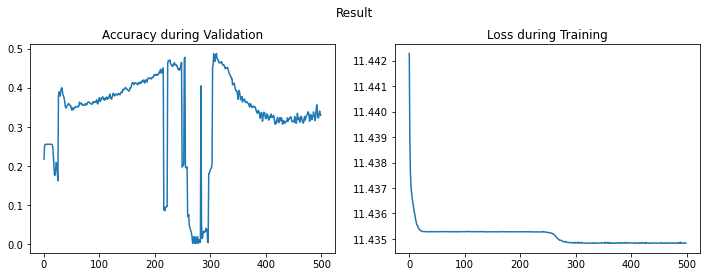

In [12]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(accs)
ax[0].set_title('Accuracy during Validation')
ax[1].plot(losses)
ax[1].set_title('Loss during Training')

plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()